In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import sys
import random
sys.path.append('../')
import torch
import torch.nn as nn
from models.modules import fc
from models.ae import AE, NRAE_L, NRAE_Q
from torch.utils.data import Dataset, DataLoader
from IPython.display import clear_output

device = f'cuda:{0}'

In [2]:
# Setup seeds
seed = 1
print(f"running with random seed : {seed}")
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

running with random seed : 1


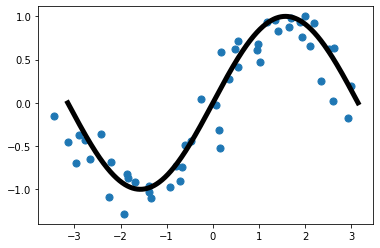

In [3]:
num_data = 50
x = np.linspace(-np.pi, np.pi, num_data)
x_true = np.linspace(-np.pi, np.pi, 10000)
y_true = np.sin(x_true)
y = np.sin(x)

data = torch.tensor([x, y], dtype=torch.float32).permute(1, 0) + 0.2*torch.randn(num_data, 2)

plt.scatter(data[:, 0], data[:, 1], s=50)
plt.plot(x_true, y_true, linewidth=5 , c='k')
plt.show()

In [4]:
class Custom_Dataset(Dataset):
    def __init__(self, dataset, nn=False, num_nn=20):
        super().__init__()
        self.data = dataset
        self.num_nn = num_nn
        self.nn = nn
        if self.nn:
            data_temp = self.data.view(len(self.data), -1).clone()
            dist_mat = torch.cdist(data_temp, data_temp)
            dist_mat_indices = torch.topk(
                dist_mat, k=self.num_nn + 1, dim=1, largest=False, sorted=True
            )
            self.dist_mat_indices = dist_mat_indices.indices[:, 1:]
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        X = self.data[idx]
        if self.nn:
            X_nn = self.data[
                self.dist_mat_indices[
                    idx, 
                    np.random.choice(range(self.num_nn), 1, replace=False)]]
            return X, X_nn
        else:
            return X

# 1. The Vanilla Autoencoder

In [14]:
x_dim = 2
z_dim = 1

encoder = fc(
    in_chan=x_dim,
    out_chan=z_dim,
    l_hidden=[1024,1024],
    activation=['relu','relu'],
    out_activation='linear'
) 
decoder = fc(
    in_chan=z_dim,
    out_chan=x_dim,
    l_hidden=[1024,1024],
    activation=['relu','relu'],
    out_activation='linear'
)
ae = AE(encoder, decoder).to(device)

dataset = Custom_Dataset(data, nn=False)
train_dl = DataLoader(dataset, batch_size=32)

optimizer = torch.optim.Adam(ae.parameters(), lr=0.001)

In [15]:
for epoch in range(3000):
    Loss = []
    for x in train_dl:
        d_loss = ae.train_step(x.to(device), optimizer=optimizer)
        Loss.append(d_loss['loss'])
    print(f'epoch:{epoch}, loss:{sum(Loss)/len(Loss)}')
    clear_output(wait=True)

epoch:2999, loss:0.003418677719309926


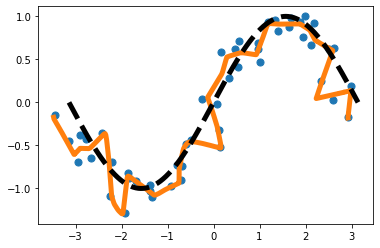

In [7]:
encoded = ae.encoder_mean(data.to(device))
min_ = encoded.min().item()
max_ = encoded.max().item()

z_data = torch.tensor(np.linspace(min_,max_,10000), dtype=torch.float32).to(device).unsqueeze(1)
gen_data = ae.decoder_mean(z_data).detach().cpu()
plt.scatter(data[:, 0], data[:, 1], s=50)
plt.plot(gen_data[:, 0], gen_data[:, 1], linewidth=5, c='tab:orange')
plt.plot(x_true, y_true, '--', linewidth=5 , c='k')
plt.show()

# 2. The Neighborhood Reconstructing Autoencoder (Linear)

In [8]:
num_nn = 15
lamb = 0.1
x_dim = 2
z_dim = 1

encoder = fc(
    in_chan=x_dim,
    out_chan=z_dim,
    l_hidden=[1024,1024],
    activation=['relu','relu'],
    out_activation='linear'
) 
decoder = fc(
    in_chan=z_dim,
    out_chan=x_dim,
    l_hidden=[1024,1024],
    activation=['relu','relu'],
    out_activation='linear'
)
nrae_l = NRAE_L(encoder, decoder, lamb=lamb).to(device)

dataset = Custom_Dataset(data, nn=True, num_nn=num_nn)
train_dl = DataLoader(dataset, batch_size=32)

optimizer = torch.optim.Adam(nrae_l.parameters(), lr=0.001)

In [9]:
for epoch in range(3000):
    Loss = []
    for x, x_nn in train_dl:
        d_loss = nrae_l.train_step(x.to(device), x_nn.to(device),optimizer=optimizer)
        Loss.append(d_loss['loss'])
    print(f'epoch:{epoch}, loss:{sum(Loss)/len(Loss)}')
    clear_output(wait=True)

epoch:2999, loss:0.018268447369337082


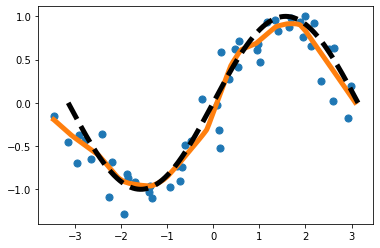

In [10]:
encoded = nrae_l.encoder_mean(data.to(device))
min_ = encoded.min().item()
max_ = encoded.max().item()

z_data = torch.tensor(np.linspace(min_,max_,10000), dtype=torch.float32).to(device).unsqueeze(1)
gen_data = nrae_l.decoder_mean(z_data).detach().cpu()
plt.scatter(data[:, 0], data[:, 1], s=50)
plt.plot(gen_data[:, 0], gen_data[:, 1], linewidth=5, c='tab:orange')
plt.plot(x_true, y_true, '--', linewidth=5 , c='k')
plt.show()

# 3. The Neighborhood Reconstructing Autoencoder (Quadratic)

In [11]:
num_nn = 15
lamb = 0.1
x_dim = 2
z_dim = 1

encoder = fc(
    in_chan=x_dim,
    out_chan=z_dim,
    l_hidden=[1024,1024],
    activation=['relu','relu'],
    out_activation='linear'
) 
decoder = fc(
    in_chan=z_dim,
    out_chan=x_dim,
    l_hidden=[1024,1024],
    activation=['relu','relu'],
    out_activation='linear'
)
nrae_q = NRAE_Q(encoder, decoder, lamb=lamb).to(device)

dataset = Custom_Dataset(data, nn=True, num_nn=num_nn)
train_dl = DataLoader(dataset, batch_size=32)

optimizer = torch.optim.Adam(nrae_q.parameters(), lr=0.001)

In [12]:
for epoch in range(3000):
    Loss = []
    for x, x_nn in train_dl:
        d_loss = nrae_q.train_step(x.to(device), x_nn.to(device),optimizer=optimizer)
        Loss.append(d_loss['loss'])
    print(f'epoch:{epoch}, loss:{sum(Loss)/len(Loss)}')
    clear_output(wait=True)

epoch:2999, loss:0.0226656561717391


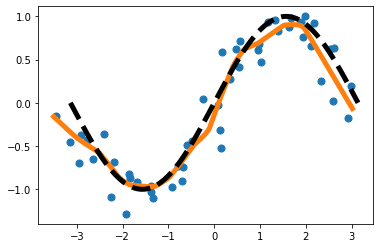

In [13]:
encoded = nrae_q.encoder_mean(data.to(device))
min_ = encoded.min().item()
max_ = encoded.max().item()

z_data = torch.tensor(np.linspace(min_,max_,10000), dtype=torch.float32).to(device).unsqueeze(1)
gen_data = nrae_q.decoder_mean(z_data).detach().cpu()
plt.scatter(data[:, 0], data[:, 1], s=50)
plt.plot(gen_data[:, 0], gen_data[:, 1], linewidth=5, c='tab:orange')
plt.plot(x_true, y_true, '--', linewidth=5 , c='k')
plt.show()